In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img_height = 400
img_width = 400
batch_size = 32
epochs = 10

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen.flow_from_directory('data/test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 7631 images belonging to 2 classes.
Found 1907 images belonging to 2 classes.


In [4]:
# for image_batch, labels_batch in train_generator:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

In [5]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    pooling=None,
    classes=1000
)

pretrained_model.trainable=False

model=Sequential()

model = tf.keras.Sequential()

for layer in pretrained_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)    

In [7]:
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples//batch_size,
  validation_data=valid_generator,
  validation_steps=valid_generator.samples//batch_size,
  epochs=epochs
)

Epoch 1/10
238/238 [==============================] - 227s 952ms/step - loss: 0.4984 - auc: 0.8524 - accuracy: 0.7722 - val_loss: 0.3572 - val_auc: 0.9213 - val_accuracy: 0.8422
Epoch 2/10
238/238 [==============================] - 225s 945ms/step - loss: 0.3102 - auc: 0.9422 - accuracy: 0.8691 - val_loss: 0.2810 - val_auc: 0.9535 - val_accuracy: 0.8914
Epoch 3/10
238/238 [==============================] - 225s 945ms/step - loss: 0.2639 - auc: 0.9581 - accuracy: 0.8979 - val_loss: 0.2270 - val_auc: 0.9699 - val_accuracy: 0.9285
Epoch 4/10
238/238 [==============================] - 226s 948ms/step - loss: 0.2341 - auc: 0.9666 - accuracy: 0.9130 - val_loss: 0.2114 - val_auc: 0.9732 - val_accuracy: 0.9211
Epoch 5/10
238/238 [==============================] - 225s 946ms/step - loss: 0.2190 - auc: 0.9708 - accuracy: 0.9195 - val_loss: 0.2155 - val_auc: 0.9713 - val_accuracy: 0.9248
Epoch 6/10
238/238 [==============================] - 229s 960ms/step - loss: 0.2027 - auc: 0.9747 - accuracy:

In [111]:
index = 26

In [112]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[index][0])
class_weights = model.layers[-1].get_weights()[0]

In [113]:
output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,2048))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

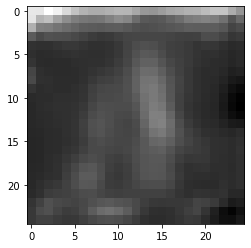

In [114]:
plt.imshow(np.reshape(output[0][0], (25, 25)), cmap="gray")

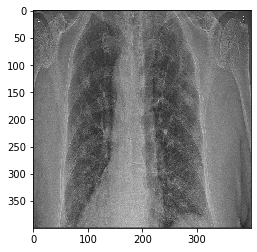

In [115]:
plt.imshow(valid_generator[index][0][0], cmap="gray")

In [116]:
prediction = model.predict(valid_generator[index][0])
np.argmax(prediction[0])

0